# Astrometry Response functions (Maps)

In [1]:
import numpy as np
import matplotlib
from matplotlib import colormaps
import matplotlib.pyplot as plt
import healpy as hp
import itertools

In [2]:
# Going from ecliptic coordinates to spherical ones.
# Velocity with respect to the cosmic frame (in galactic coordinates(l, b) = (264◦, 48◦)):
v_theta = (np.pi/2)-np.radians(-7.145) # (pi/2 - Declination) E[0,pi]
v_phi = np.radians(167.78) # Right Ascension E[0,2pi]

In [3]:
# unit vector in R3. 
# Given two angles, \theta E[0,pi] and \phi E[0,2pi], the next function retuns its cartesian coordinates
def skyvec(theta,phi): 
    st = np.sin(theta)
    cp = np.cos(phi)
    sp = np.sin(phi)
    ct = np.cos(theta)
    return np.array([st*cp,st*sp,ct])

print(skyvec(2,3))
print(np.dot(skyvec(2,3),skyvec(2,3)))

[-0.90019763  0.12832006 -0.41614684]
1.0


## Ploting random stars in the Sky

In [4]:
np.random.seed(7)
n_stars = 600
npair = n_stars*(n_stars -1)/2
theta = np.arccos(np.random.uniform(-1,1,n_stars))
phi = np.random.uniform(0,2*np.pi,n_stars)
#theta = np.random.uniform(0.1, np.pi, n_stars)  # colatitude E[0, pi]
#phi = np.random.uniform(0.1, 2*np.pi, n_stars) # longitude [0, 2pi]

n1=np.array(skyvec(theta, phi)).T#.reshape(n_stars,3)
#n2=np.array(skyvec(theta, phi)).T#.reshape(n_stars,3)
#n1[7]

#print(n1)
#print(n2[1])
print(npair)
#print(n1)
print(np.dot(n1[2],n1[2]))
np.dot(n1[1],n1[1])

179700.0
1.0000000000000002


1.0000000000000002

In [5]:
# Note that alpha and gamma give scalars as result.

def hola(y):
    if y==0:
        hola=0
    else:
        hola= y*np.log(y)
    return hola

def alpha(v,n1,n2):
    cos_zeta = np.dot(n1,n2)
    y = (1- cos_zeta)/2
    n1v = np.dot(n1,v)
    n2v = np.dot(n2,v)
    num = -np.pi*(2*y-1)*(n1v-n2v)*(n1v+n2v)*((y-1)*(2*y+1) - 3*hola(y))
    den = 6*n1v*(y-1)**3
    return num/den

def gamma(v,n1,n2):
    y = (1-np.dot(n1,n2))/2
    n1v = np.dot(n1,v)
    n2v = np.dot(n2,v)
    num = np.pi*y*(n1v+n2v)*((y-1)*(2*y+1) - 3*hola(y))
    den = 3*n1v*((y-1)**2)
    return num/den

I_3 = np.eye(3)
def delta_ij(i, j):
    return 1 if i == j else 0

def GTanalytic_H1_00(v, n1, n2):
    y = (1-np.dot(n1,n2))/2 # change to zeta if phi is not 0.
    n1v = np.dot(n1,v)
    n2v = np.dot(n2,v)
    alph = alpha(v,n1,n2)
    gamm = gamma(v,n1,n2)
    t1 = I_3[0,0] * (alph*(2*y+1/(1-2*y) - 1) -2*gamm*n2v)
    t2 = np.outer(n1, n1)[0,0]*( alph/(2*y-1) + 2*gamm*n2v) +alph*(np.outer(n1, n2)[0,0]+np.outer(n2, n1)[0,0])
    t3 = np.outer(n2, n2)[0,0]*alph/(2*y-1) + 2*gamm*(2*y-1)*np.outer(n1, v)[0,0] + 2*gamm*np.outer(n2, v)[0,0]
    return t1+t2+t3 #alpha*coeff_alpha/(2*y-1) + 2*beta*coeff_beta

## Changing the color of the map according to a function

In [8]:
nside = 64
npix = hp.nside2npix(nside)

#frame velocity 
vtheta, vphi = hp.pix2ang(nside, np.arange(npix))
vdir = skyvec(vtheta,vphi)

In [7]:
# Defined to save the results
H1f_00 = np.zeros(npix)

for strpair in itertools.combinations(np.arange(n_stars),2):
    idx_p,idx_q = strpair                
    p = skyvec(theta[idx_p],phi[idx_p])
    q = skyvec(theta[idx_q],phi[idx_q])     
    #v=skyvec(v_theta, v_phi)
    H1f_00 += GTanalytic_H1_00(vdir, p, q)       
                

In [18]:
print(H1f_00)
#len(H1f_11)

[  -2172.83605927    4204.67452803 -113923.52193921 ...     584.07403353
    2199.56031195   -4213.87368062]


Number of stars: 600
Number of pairs: 179700.0
Number of pixels: 49152


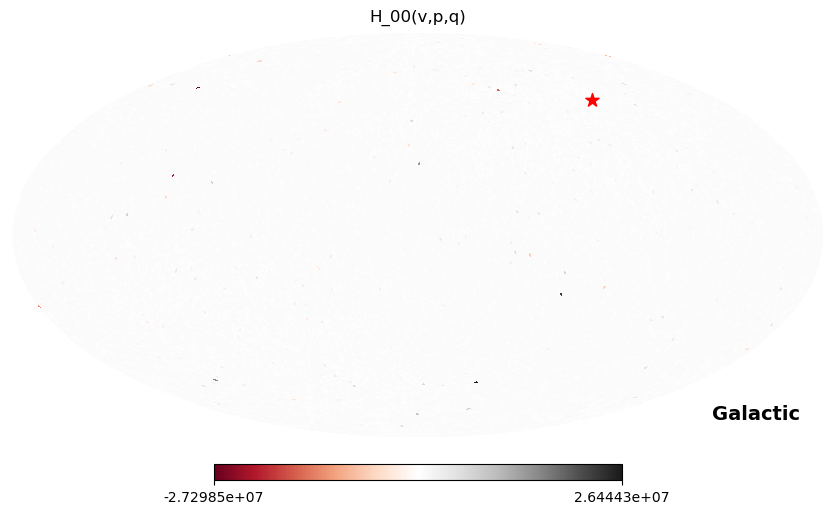

In [20]:
#m = np.arange(len(resultsH0))
print('Number of stars:',n_stars)
print('Number of pairs:',npair)
print('Number of pixels:',npix)
hp.mollview(H1f_00,title='H_00(v,p,q)', cmap='RdGy',coord=['E','G'])
hp.projscatter(v_theta, v_phi,marker='*',s=100,color='r', coord=['E','G']) 

In [29]:
nside = 32
npix = hp.nside2npix(nside)

# Stars positions
stheta, sphi = hp.pix2ang(nside, np.arange(npix))
dir = skyvec(stheta,sphi) #.reshape(npix,3)

print(np.shape(dir))
#len(n2_pix)

(3, 12288)


In [30]:
# Defined to save the results
#H1_00 = np.zeros(npix)

theta0 = np.deg2rad(48) 
phi0 = np.deg2rad(264)
q_fix = np.array([1,0,0]).reshape(3,1)
v = skyvec(theta0,phi0).reshape(3,1)

Map_H1_00= GTanalytic_H1_00(v, dir, q_fix) 

ValueError: shapes (3,12288) and (3,1) not aligned: 12288 (dim 1) != 3 (dim 0)